In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import math
import os
import shutil
from sklearn.model_selection import train_test_split
import os

In [2]:
class SelfAttention(nn.Module):
  def __init__(self, n_heads, embd_dim, in_proj_bias=True, out_proj_bias=True):
    super().__init__()
    self.n_heads = n_heads
    self.in_proj = nn.Linear(embd_dim, 3 * embd_dim, bias=in_proj_bias)
    self.out_proj = nn.Linear(embd_dim, embd_dim, bias=out_proj_bias)

    self.d_heads = embd_dim // n_heads

  def forward(self, x, casual_mask=False):
    # x: (batch_size, seq_len, dim)

    batch_size, seq_len, d_emed = x.shape

    interim_shape = (batch_size, seq_len, self.n_heads, self.d_heads)

    # (batch_size, seq_len, dim) -> 3 * (batch_size, seq_len, d_embed)
    q, k, v = self.in_proj(x).chunk(3, dim=-1)

    # change the shape of q, k and v to match the interim shape
    q = q.view(interim_shape)
    k = k.view(interim_shape)
    v = v.view(interim_shape)

    # swap the elements within matrix using transpose
    # take n_heads before seq_len, like that: (batch_size, n_heads, seq_len, d_embed)
    q = q.transpose(1, 2)
    k = k.transpose(1, 2)
    v = v.transpose(1, 2)

    # calculate the attention
    weight = q @ k.transpose(-1, -2)

    if casual_mask:
        # mask where the upper traingle (above the prinicpal dagonal) is 1
        mask = torch.ones_like(weight, dtype=torch.bool).triu(1)
        # fill the upper traingle with -inf
        weight.masked_fill_(mask, -torch.inf)

    weight /= math.sqrt(self.d_heads)

    weight = F.softmax(weight, dim=-1)

    # (batch_size, h_heads, seq_len, dim / h)
    output = weight @ v

    # (batch_size, h_heads, seq_len, dim / h) -> (batch_size, seq_len, n_heads, dim / h)
    output = output.transpose(1, 2)

    # change the shape to the shape of out_proj
    output = output.reshape((batch_size, seq_len, d_emed))

    output = self.out_proj(output)

    return output

In [3]:
class AttentionBlock(nn.Module):
  def __init__(self, channels):
      super().__init__()
      self.groupnorm = nn.GroupNorm(32, channels)
      self.attention = SelfAttention(1, channels)

  def forward(self, x):
      # x: (batch_size, channels, h, w)
      residual = x.clone()

      # (batch_size, channels, h, w) -> (batch_size, channels, h, w)
      x = self.groupnorm(x)

      n, c, h, w = x.shape

      # (batch_size, channels, h, w) -> (batch_size, channels, h * w)
      x = x.view((n, c, h * w))

      # (batch_size, channels, h * w) -> (batch_size, h * w, channels)
      x = x.transpose(-1, -2)

      # perform self-attention without mask
      # (batch_size, h * w, channels) -> (batch_size, h * w, channels)
      x = self.attention(x)

      # (batch_size, h * w, channels) -> (batch_size, channels, h * w)
      x = x.transpose(-1, -2)

      # (batch_size, channels, h * w) -> (batch_size, channels, h, w)
      x = x.view((n, c, h, w))

      # (batch_size, channels, h, w) -> (batch_size, channels, h, w)
      x += residual

      return x

In [4]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.groupnorm1 = nn.GroupNorm(32, in_channels)
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    self.groupnorm2 = nn.GroupNorm(32, out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    if in_channels == out_channels:
      self.residual_layer = nn.Identity()
    else:
      self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)

  def forward(self, x):
    # x: (batch_size, in_channels, h, w)
    residue = x.clone()

    x = self.groupnorm1(x)
    x = F.selu(x)
    x = self.conv1(x)
    x = self.groupnorm2(x)
    x = self.conv2(x)

    return x + self.residual_layer(residue)

In [5]:
class Encoder(nn.Sequential):
    def  __init__(self):
        super().__init__(
            # (batch_size, channel, h, w) -> (batch_size, 128, h, w)
            nn.Conv2d(3, 128, kernel_size=3, padding=1),

            # (batch_size, 128, h, w) -> (batch_size, 128, h, w)
            ResidualBlock(128, 128),

            # (batch_size, 128, h, w) -> (batch_size, 128, h / 2, w / 2)
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0),

            # (batch_size, 128, h / 2, w / 2) -> (batch_size, 256, h / 2, w / 2)
            ResidualBlock(128, 256),

            # (batch_size, 256, h / 2, w / 2) -> (batch_size, 256, h / 2, w / 2)
            ResidualBlock(256, 256),

            # (batch_size, 256, h / 2, w / 2) -> (batch_size, 256, h / 4, w / 4)
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=0),

            # (batch_size, 256, h / 4, w / 4) -> (batch_size, 512, h / 4, w / 4)
            ResidualBlock(256, 512),

            # (batch_size, 512, h / 4, w / 4) -> (batch_size, 512, h / 4, w / 4)
            ResidualBlock(512, 512),

            # (batch_size, 512, h / 4, w / 4) -> (batch_size, 512, h / 8, w / 8)
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=0),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            ResidualBlock(512, 512),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            ResidualBlock(512, 512),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            ResidualBlock(512, 512),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            AttentionBlock(512),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            ResidualBlock(512, 512),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            nn.GroupNorm(32, 512),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            nn.SiLU(),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 8, h / 8, w / 8)
            nn.Conv2d(512, 8, kernel_size=3, padding=1),

            # (batch_size, 8, h / 8, w / 8) -> (batch_size, 8, h / 8, w / 8)
            nn.Conv2d(8, 8, kernel_size=1, padding=0)
        )
    def forward(self, x):
        # x: (batch_size, channel, h, w)

        for module in self:
            if isinstance(module, nn.Conv2d) and module.stride == (2, 2):
                x = F.pad(x, (0, 1, 0, 1))  # (left, right, top, bottom)
            x = module(x)

        # (batch_size, 8, h / 8, w / 8) -> two tensors of shape (batch_size, 4, h / 8, w / 8)
        mean, log_variance = torch.chunk(x, 2, dim=1)

        # Clamp log variance between -30 and 20
        log_variance = torch.clamp(log_variance, -30, 20)

        # Reparameterization trick
        std = torch.exp(0.5 * log_variance)
        eps = torch.randn_like(std)
        x = mean + eps * std

        # Scale the latent representation
        x *= 0.18215

        return x


In [6]:
class Decoder(nn.Sequential):
    def __init__(self):
        super().__init__(
            # (batch_size, 4, 32, 32) -> (batch_size, 512, 32, 32)
            nn.Conv2d(4, 512, kernel_size=3, padding=1),

            # (batch_size, 512, 32, 32) -> (batch_size, 512, 32, 32)
            ResidualBlock(512, 512),

            # (batch_Size, 512, 32, 32) -> (batch_size, 512, 32, 32)
            AttentionBlock(512),

            # (batch_size, 512, 32, 32) -> (batch_size, 512, 32, 32)
            ResidualBlock(512, 512),

            # (batch_size, 512, 32, 32) -> (batch_size, 512, 32, 32)
            ResidualBlock(512, 512),

            # (batch_size, 512, 32, 32) -> (batch_size, 512, 32, 32)
            ResidualBlock(512, 512),

            # (batch_size, 512, 32, 32) -> (batch_size, 512, 64, 64)
            nn.Upsample(scale_factor=2),

            # (batch_size, 512, 64, 64) -> (batch_size, 512, 64, 64)
            nn.Conv2d(512, 512, kernel_size=3, padding=1),

            # (batch_size, 512, 64, 64) -> (batch_size, 512, 64, 64)
            ResidualBlock(512, 512),

            # (batch_size, 512, 64, 64) -> (batch_size, 512, 64, 64)
            ResidualBlock(512, 512),

            # (batch_size, 512, 64, 64) -> (batch_size, 512, 64, 64)
            ResidualBlock(512, 512),

            # (batch_size, 512, 64, 64) -> (batch_size, 512, 128, 128)
            nn.Upsample(scale_factor=2),

            # (batch_size, 512, 128, 128) -> (batch_size, 512, 128, 128)
            nn.Conv2d(512, 512, kernel_size=3, padding=1),

            # (batch_size, 512, 128, 128) -> (batch_size, 256, 128, 128)
            ResidualBlock(512, 256),

            # (batch_size, 256, 128, 128) -> (batch_size, 256, 128, 128)
            ResidualBlock(256, 256),

            # (batch_size, 256, 128, 128) -> (batch_size, 256, 128, 128)
            ResidualBlock(256, 256),

            # (batch_size, 256, 128, 128) -> (batch_size, 256, 256, 256)
            nn.Upsample(scale_factor=2),

            # (batch_size, 256, 256, 256) -> (batch_size, 256, 256, 256)
            nn.Conv2d(256, 256, kernel_size=3, padding=1),

            # (batch_size, 256, 256, 256) -> (batch_size, 128, 256, 256)
            ResidualBlock(256, 128),

            # (batch_size, 128, 256, 256) -> (batch_size, 128, 256, 256)
            ResidualBlock(128, 128),

            # (batch_size, 128, 256, 256) -> (batch_size, 128, 256, 256)
            ResidualBlock(128, 128),

            nn.GroupNorm(32, 128),

            nn.SiLU(),

            # (batch_size, 128, 256, 256) -> (batch_size, 3, 256, 256)
            nn.Conv2d(128, 3, kernel_size=3, padding=1),
        )
    def forward(self, x):
        # x: (batch_size, 4, h / 8, w / 8)

        # remove the scaling adding by the encoder
        x /= 0.18215

        for module in self:
            x = module(x)

        # (batch_size, 3, h, w)
        return x

In [7]:
class CustomVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        x_reconstructed = self.decode(z)
        return x_reconstructed

    def load_pretrained_weights(self, weight_path):
        self.load_state_dict(torch.load(weight_path))


In [8]:
from diffusers import AutoencoderKL

class DiffusersCompatibleVAE(AutoencoderKL):
    def __init__(self, vae):
        super().__init__()
        self.vae = vae

    def encode(self, x):
        mean, log_var = self.vae.encoder(x)
        print("mean")
        return mean, log_var

    def decode(self, z, **kwargs):
        print("Input shape:", z.shape)
        out = self.vae.decoder(z).unsqueeze(0)
        print(out.shape)
        return out


In [9]:
from huggingface_hub import snapshot_download

snapshot_download('CompVis/stable-diffusion-v1-4', local_dir="./model")


Fetching 33 files:   0%|          | 0/33 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/17.1k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

pytorch_model.fp16.bin:   0%|          | 0.00/608M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

pytorch_model.fp16.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.non_ema.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


(…)fusion_pytorch_model.non_ema.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

v1-variants-scores.jpg:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

'/content/model'

In [10]:
import torch

weights = torch.load("/content/vae_model_epoch_9.pth", map_location='cpu')

new_weights = {}
for k, v in weights.items():
    # First, remove underscores from keys like 'groupnorm_1', 'conv_1'
    new_key = k.replace("_", "")

    # Then add underscores in specific patterns to match 'CustomVAE'
    new_key = new_key.replace("residuallayer", "residual_layer") \
                    .replace("inproj", "in_proj") \
                    .replace("outproj", "out_proj")

    new_weights[new_key] = v

vae = CustomVAE()
vae.load_state_dict(new_weights)

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
vae = vae.to(device)


In [11]:
from diffusers import StableDiffusionPipeline
import torch

vae = CustomVAE()
compatible_vae = DiffusersCompatibleVAE(vae=vae)
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", vae=compatible_vae)
pipe = pipe.to("cuda")

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [14]:
# Generate an image
prompt = "a photo of a happy dog"
image = pipe(prompt, num_inference_steps=50).images[0]


  0%|          | 0/50 [00:00<?, ?it/s]

Input shape: torch.Size([1, 4, 64, 64])
torch.Size([1, 1, 3, 512, 512])


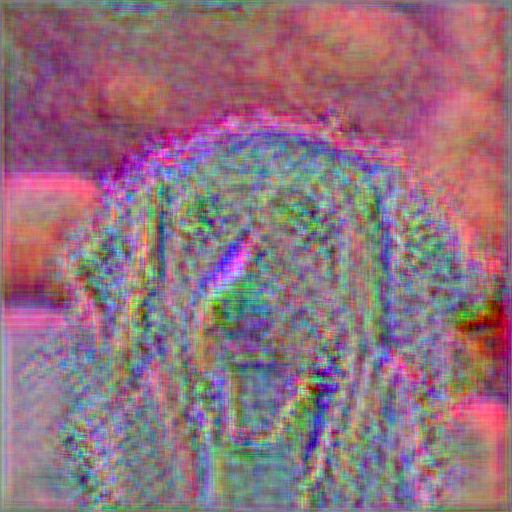

In [15]:
image